In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
import os
import re

import sys
sys.path.append("c:/Users/Kyselica/Desktop/kyselica/classification_of_light_curves/src")
sys.path.append("c:/Users/Kyselica/Desktop/kyselica/classification_of_light_curves/")

from src.data.filters import *
from src.config import FilterConfig

%matplotlib inline


In [2]:
REAL_DATA_PATH = "c:/Users/Kyselica/Desktop/kyselica/charon_share/Fall_2021_csv"
SYNTHETIC_DATA_PATH = "c:/Users/Kyselica/Desktop/kyselica/classification_of_light_curves/resources/synthetic/all_colors"

FILTER_CFG = FilterConfig()
FILTER_CFG.n_bins = 30
FILTER_CFG.n_gaps = 2
FILTER_CFG.gap_size = 10
FILTER_CFG.rms_ratio = .0
FILTER_CFG.non_zero_ratio = 0.8

In [3]:
def load_csv_file(name, regex=r'.*'):
    data = {}
    for filename in glob.iglob(f"{REAL_DATA_PATH}/*{name}*.csv"):
        name = os.path.split(filename)[1][:-(len(".csv"))]
        if re.search(regex, name):
            df = pd.read_csv(filename)
            data[name] = df
    return data

def load_npy_file(name, regex=r'.*'):
    data = {}
    for filename in glob.iglob(f"{SYNTHETIC_DATA_PATH}/*{name}*.npy"):
        name = os.path.split(filename)[1][:-(len(".npy"))]
        if re.search(regex, name):
            df = np.load(filename)
            data[name] = df
    return data

def synthetic_by_angles(data, phase_angle, obs_angle):
    PHASE_ANGLE_START = 0#0
    PHASE_ANGLE_END = 120
    PHASE_ANGLE_NUM_STEPS = 40

    OBS_ANGLE_START = 0
    OBS_ANGLE_END = 90
    OBS_ANGLE_NUM_STEPS = 45
    phase_angles = np.linspace(PHASE_ANGLE_START, PHASE_ANGLE_END, num=PHASE_ANGLE_NUM_STEPS, endpoint=True)
    observation_angles = np.linspace(OBS_ANGLE_START, OBS_ANGLE_END, num=OBS_ANGLE_NUM_STEPS, endpoint=True)


    ph_i = int(phase_angle // (PHASE_ANGLE_END // PHASE_ANGLE_NUM_STEPS))
    obs_i = int(obs_angle // (OBS_ANGLE_END // OBS_ANGLE_NUM_STEPS))
    print(ph_i, obs_i, ph_i * OBS_ANGLE_NUM_STEPS + obs_i)
    
    x = data[ph_i * OBS_ANGLE_NUM_STEPS + obs_i]
    x = -2.5 * np.log10(x + 0.000000001)
    return x

def real_by_angle(dd, phs_from, phs_to):
    x = dd[dd["Phase"] >= phs_from]
    x = x[x["Phase"] <= phs_to]
    x = x.iloc[0, 3:].to_numpy()
    
    return x


# DATA STATS

In [4]:
def get_stats(data):
    stats = {}
    stats["num_objects"] = len(data["Object ID"].unique())
    stats["num_of_tracks"] = len(data["Track ID"].unique())
    stats["track_size"] = [np.sum(data["Object ID"] == tID)  for tID in data["Object ID"].unique()]
    stats["phase_angles"] = data["Phase"].to_numpy()

    return stats
    
def filter_data(data,filter_cfg):
    to_filter = data.iloc[:, 3:].to_numpy()
    ok = get_filter_continuous(to_filter, n_bins=filter_cfg.n_bins, gap=filter_cfg.n_gaps, continous_gap=filter_cfg.gap_size)
    ok = np.logical_and(ok, get_filter_ratio(to_filter, ratio=filter_cfg.non_zero_ratio))
    if filter_cfg.rms_ratio != 0:
        ok = np.logical_and(ok,get_rms_filter(to_filter, rms_ratio=filter_cfg.rms_ratio))

    filtered_data = data[ok]

    return filtered_data

def plot_phase_angle_stats(track_size, phase_angles, text=""):
    f = plt.figure(figsize=(15,3))
    ax1 = f.add_subplot(131)
    _ = ax1.hist(track_size, bins=10, orientation="horizontal")
    ax1.set_xlabel('Number of Objects')
    ax1.set_ylabel('Number of period light curves')
    ax1.set_title("Number of LC to objects")

    ax2 = f.add_subplot(132)
    _ = ax2.hist(phase_angles, bins=range(0,120,2),orientation="horizontal")
    ax2.set_ylabel('Phase angle')
    ax2.set_xlabel('Number of period light curves')
    ax2.set_title("Number of LC to Phase angle")

    ax3 = f.add_subplot(133)
    ax3.text(0,0.,text)
    ax3.set_axis_off()

    

def show_stats(name, regex=r'.*'):
    DATA = load_csv_file(name, regex)
    for sub_name in DATA:
        data = DATA[sub_name]
        stats1 = get_stats(data)
        filtered = filter_data(data, FILTER_CFG)
        stats2 = get_stats(filtered)

        text = f'''
                {sub_name}
        --------------------------------------------
        Original
            objects: {stats1["num_objects"]} 
            tracks: {stats1["num_of_tracks"]} 
            periods: {np.sum(stats1["track_size"])}
        After filtration: 
            objects: {stats2["num_objects"]} 
            tracks: {stats2["num_of_tracks"]} 
            periods: {np.sum(stats2["track_size"])}
        --------------------------------------------
        '''

        plot_phase_angle_stats(stats2["track_size"], stats2["phase_angles"], text)

def save_npy(name, regex=r'.*', output_path=""):
    DATA = load_csv_file(name, regex)
    data = np.empty((0,300))
    for sub_name in DATA:
        filtered = filter_data(DATA[sub_name], FILTER_CFG)

        x = filtered.iloc[:, 3:].to_numpy()
        print(x.shape)
        data = np.concatenate([data, x],axis=0)

    np.save(f"{output_path}/{name}.npy", data)

    print(data.shape)


## FALCON 9 

c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  func(*args, **kwargs)
c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


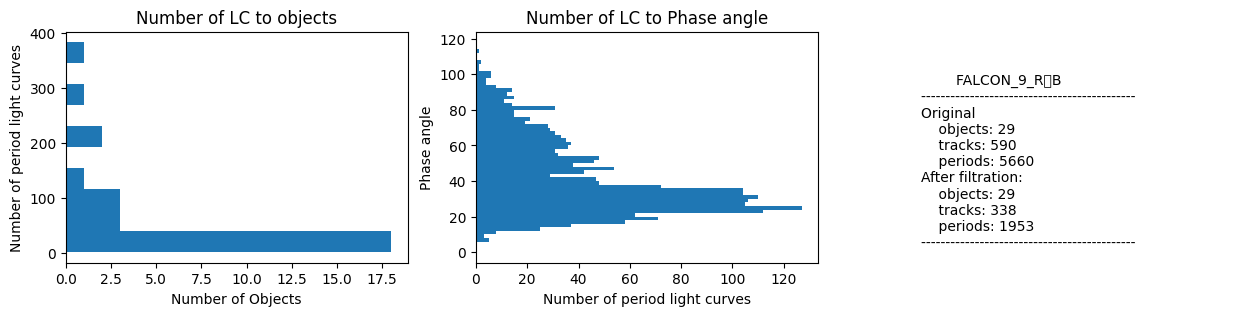

In [279]:
name = "FALCON_9"
show_stats(name)

## CZ-3

c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  func(*args, **kwargs)
c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


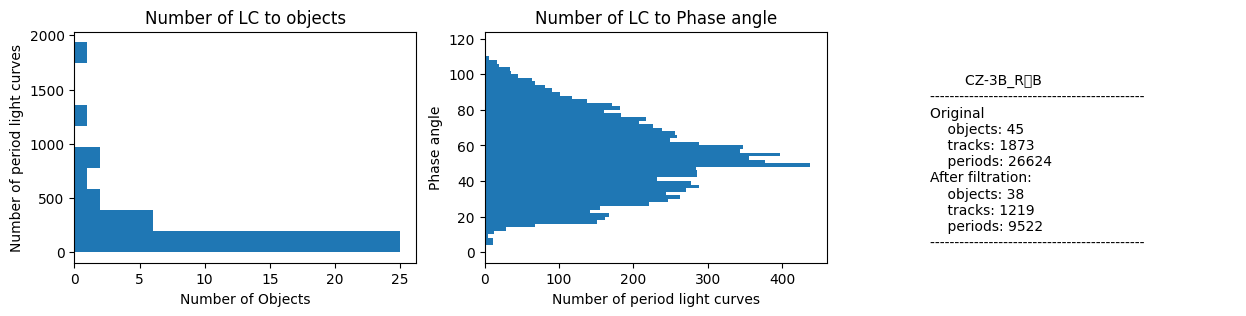

In [295]:
name = "CZ-3"
show_stats(name, regex=r'^CZ-3B+')

## H2A

c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  func(*args, **kwargs)
c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


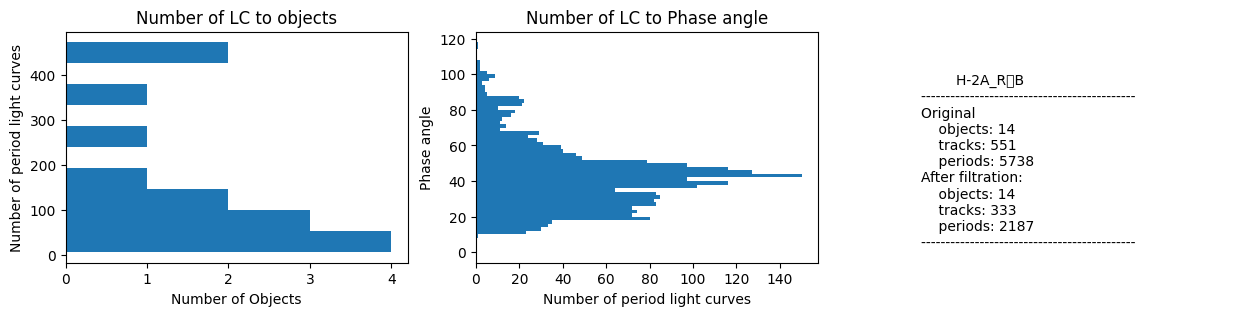

In [296]:
name = "H-2A"
show_stats(name, regex=r'H-2A_R.B$')

## ATLAS 5

c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  func(*args, **kwargs)
c:\Users\Kyselica\Documents\programs\anaconda\envs\ml\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 61564 (\uf07c) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


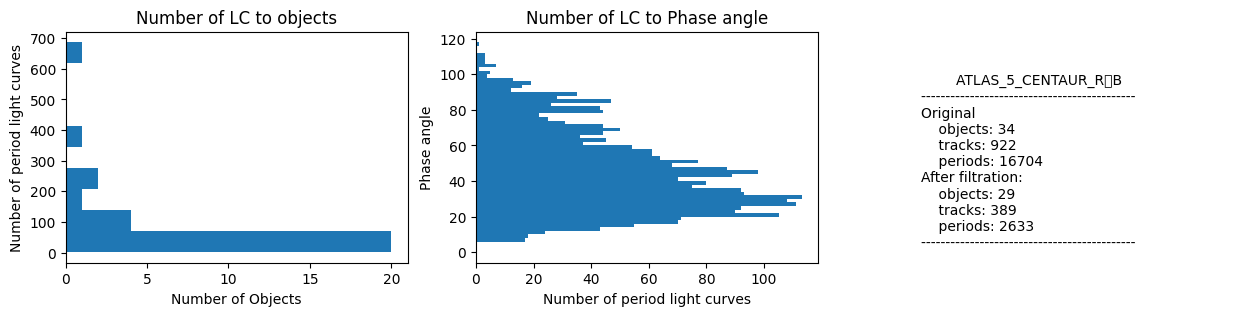

In [452]:
name = "ATLAS_5"
show_stats(name, regex=r'^ATLAS_5_CENTAUR_R.B$')

## GLOBALSTAR

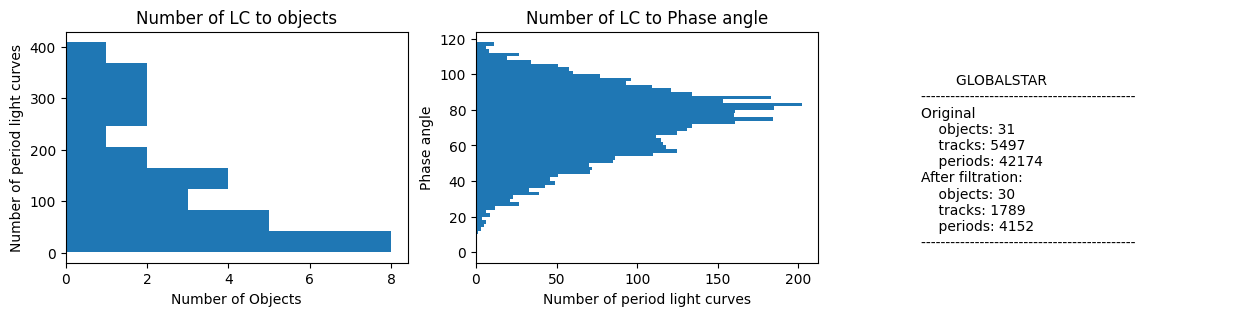

In [301]:
name = "Globalstar"
show_stats(name, regex=r'^GLOBALSTAR$')

# COMPARISON

In [7]:
SYNTHETIC_DATA_PATH = "c:/Users/Kyselica/Desktop/kyselica/classification_of_light_curves/resources/synthetic/all_colors"


# d = load_npy_file("atlas")["atlas_5"]
# d2 = load_csv_file("atlas_5", regex=r'^ATLAS_5_CENTAUR_R.B$')

# d = load_npy_file("globalstar")["globalstar"]
# d2 = load_csv_file("globalstar", regex=r'^GLOBALSTAR$')

# d = load_npy_file("falcon_9")["falcon_9"]
# d2 = load_csv_file("falcon_9", regex=r'.*')

# d = load_npy_file("cz_3")["cz_3"]
# d2 = load_csv_file("cz-3", regex=r'CZ-3B.*')

d = load_npy_file("h2a")["h2a"]
d2 = load_csv_file("h-2a", regex=r'H-2A.*B$')

In [8]:
dd = filter_data(d2[list(d2.keys())[0]], FILTER_CFG)


23 15 1050
2.7249028826159885
5.4863333333333335


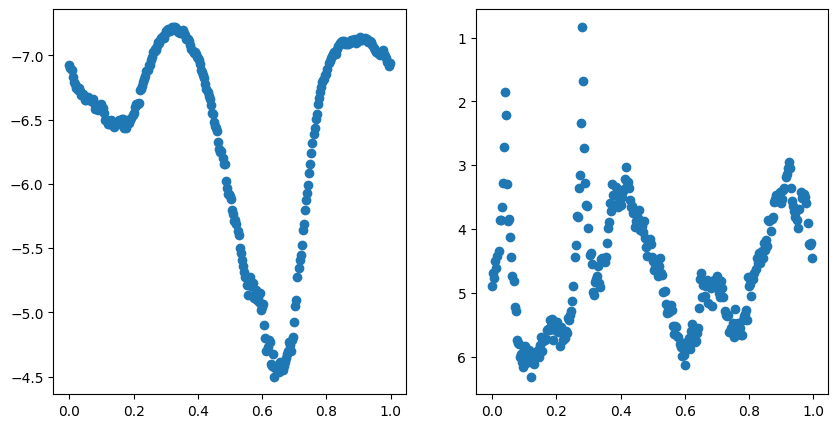

In [16]:
PHS = 70

x = synthetic_by_angles(d, PHS,30)
z = real_by_angle(dd, phs_from=PHS-1.5, phs_to=PHS+1.5)

print(max(x) - min(x))
print(max(z[z!=0]) - min(z[z!=0]))

fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
axs[0].invert_yaxis()
# axs[0].axis(ymin=5, ymax=-10)
axs[0].scatter(np.arange(300)/300, x)

axs[1].scatter(np.arange(300)[z!=0] / 300, z[z!=0])
axs[1].invert_yaxis()
# axs[1].axis(ymin=6, ymax=2)

In [498]:
output_path = "c:/Users/Kyselica/Desktop/kyselica/classification_of_light_curves/resources/real_mmt2"

save_npy("h-2a", regex=r'H-2A_R.B$', output_path=output_path)

(2187, 300)
(2187, 300)
